In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import mcu
import angles_dataset_generator as adg
from scipy.optimize import dual_annealing


In [17]:
noise = False
control_vars = adg.get_array_of_control_vars(noise=noise)
response_matrix = adg.get_array_of_figures(control_vars, noise=noise) 

In [19]:
standardized_x, centered_y, edges, y_means, y_scaler, x_means, x_stds = mcu.prepare_data(control_vars, response_matrix)
q = mcu.solve_semidefinite_programming(standardized_x, centered_y, edges)
u, s = mcu.get_eigen_decomposition(q)
m_ = 3
ld_embedding = mcu.reduce_dimension(u, s, m_)
regression_matrix = mcu.regress(ld_embedding, standardized_x)

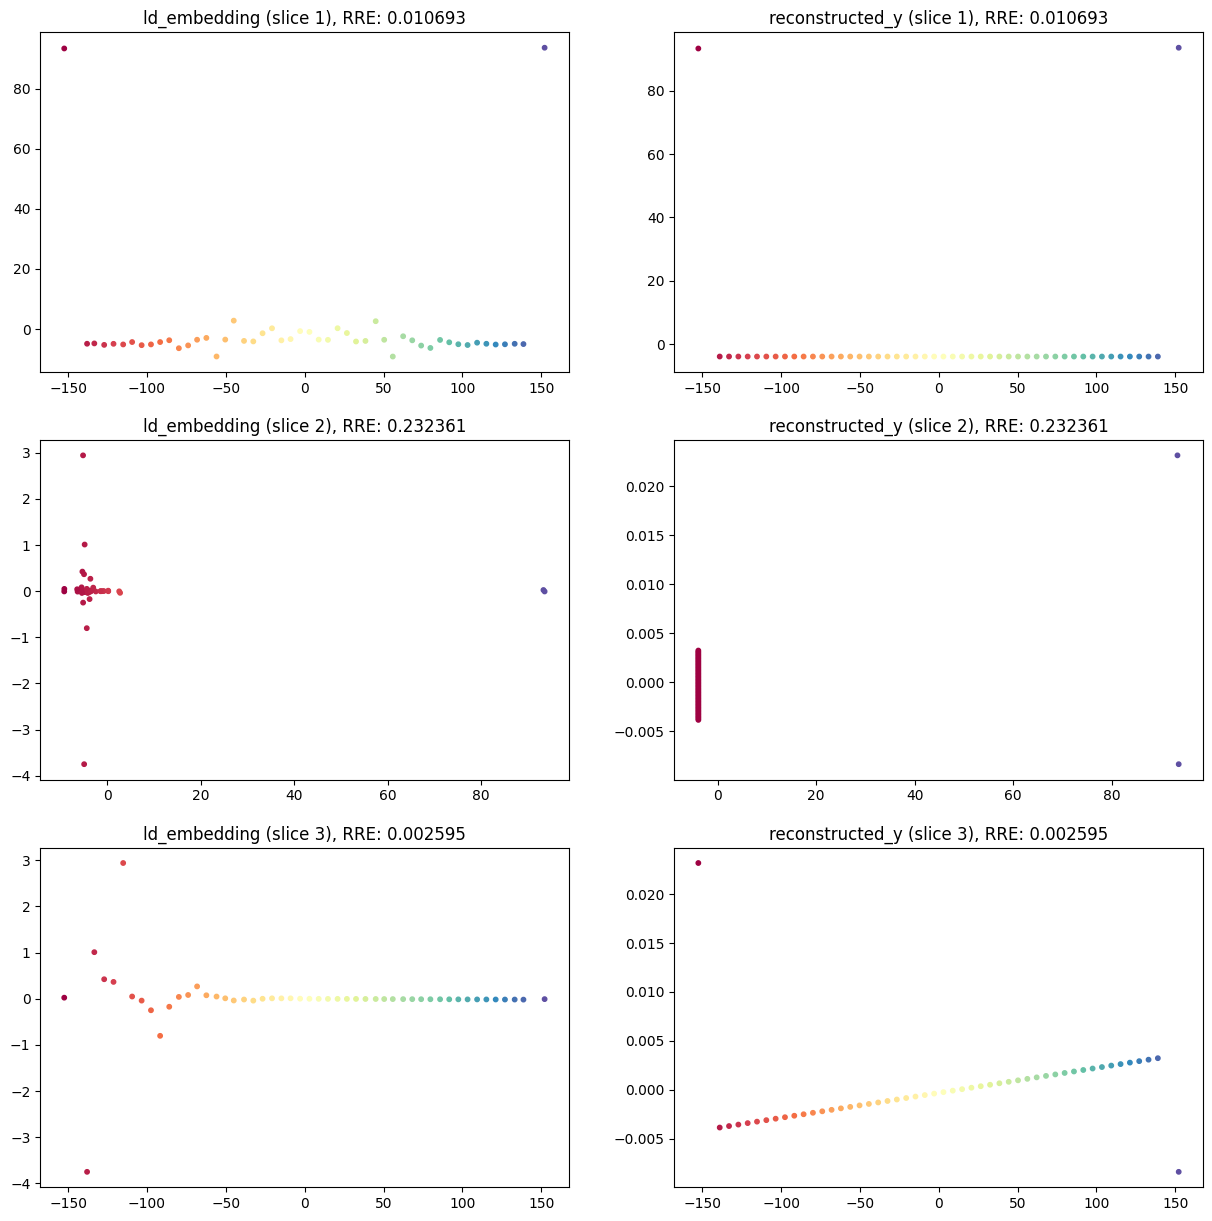

In [20]:
reconstructed_y = np.dot(standardized_x, regression_matrix)
mcu.plot_two_embeddings_3d(ld_embedding, reconstructed_y)

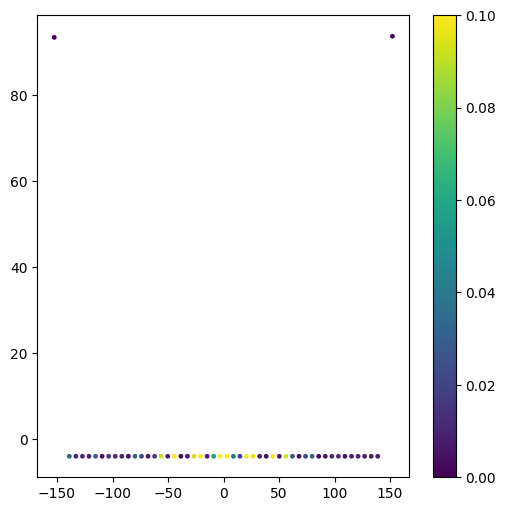

0.011762627995261819


In [21]:
rre = mcu.compute_rre(ld_embedding, reconstructed_y)
mcu.plot_rre_heatmap(rre, reconstructed_y)
print(np.median(rre))

In [24]:
test_control_vars = adg.get_array_of_control_vars(noise=noise)
test_pc = adg.get_array_of_figures(control_vars, noise=noise)

test_control_vars

array([[ 1.,  2.,  3.],
       [ 2.,  3.,  4.],
       [ 3.,  4.,  5.],
       [ 4.,  5.,  6.],
       [ 5.,  6.,  7.],
       [ 6.,  7.,  8.],
       [ 7.,  8.,  9.],
       [ 8.,  9., 10.],
       [ 9., 10., 11.],
       [10., 11., 12.],
       [11., 12., 13.],
       [12., 13., 14.],
       [13., 14., 15.],
       [14., 15., 16.],
       [15., 16., 17.],
       [16., 17., 18.],
       [17., 18., 19.],
       [18., 19., 20.],
       [19., 20., 21.],
       [20., 21., 22.],
       [21., 22., 23.],
       [22., 23., 24.],
       [23., 24., 25.],
       [24., 25., 26.],
       [25., 26., 27.],
       [26., 27., 28.],
       [27., 28., 29.],
       [28., 29., 30.],
       [29., 30., 31.],
       [30., 31., 32.],
       [31., 32., 33.],
       [32., 33., 34.],
       [33., 34., 35.],
       [34., 35., 36.],
       [35., 36., 37.],
       [36., 37., 38.],
       [37., 38., 39.],
       [38., 39., 40.],
       [39., 40., 41.],
       [40., 41., 42.],
       [41., 42., 43.],
       [42., 43.

In [25]:
test_pc

[array([0.        , 0.05263158, 0.10526316, ..., 3.        , 3.        ,
        3.        ]),
 array([0.        , 0.10526316, 0.21052632, ..., 4.        , 4.        ,
        4.        ]),
 array([0.        , 0.15789474, 0.31578947, ..., 5.        , 5.        ,
        5.        ]),
 array([0.        , 0.21052632, 0.42105263, ..., 6.        , 6.        ,
        6.        ]),
 array([0.        , 0.26315789, 0.52631579, ..., 7.        , 7.        ,
        7.        ]),
 array([0.        , 0.31578947, 0.63157895, ..., 8.        , 8.        ,
        8.        ]),
 array([0.        , 0.36842105, 0.73684211, ..., 9.        , 9.        ,
        9.        ]),
 array([ 0.        ,  0.42105263,  0.84210526, ..., 10.        ,
        10.        , 10.        ]),
 array([ 0.        ,  0.47368421,  0.94736842, ..., 11.        ,
        11.        , 11.        ]),
 array([ 0.        ,  0.52631579,  1.05263158, ..., 12.        ,
        12.        , 12.        ]),
 array([ 0.        ,  0.57894737

In [27]:
def predictive_optimization(y_nom, centered_y, ld_embedding, regression_matrix, y_means, y_scaler, k=5):
    y_nom = (y_nom - y_means) / y_scaler
    distances = np.linalg.norm(centered_y - y_nom, axis=1)
    neighbours = np.argsort(distances)[:k]

    def y_error(v):
        err_diff = (np.linalg.norm(v - ld_embedding[neighbours]) -
                    np.linalg.norm(y_nom - centered_y[neighbours]))
        sum_err = np.sum(err_diff ** 2)
        return sum_err

    def x_error(x):
        return y_error(np.dot(x, regression_matrix))

    lw = [-1.3] * 3
    up = [1.3] * 3

    x_opt = dual_annealing(x_error, bounds=list(zip(lw, up)))
    return x_opt.x, x_error(x_opt.x)


In [30]:
x_opts = []
for (pc, control_var) in zip(test_pc, test_control_vars):
    x_opt, x_err = predictive_optimization(pc, centered_y, ld_embedding, regression_matrix, y_means, y_scaler)
    x_opt = x_opt * x_stds + x_means
    x_opts.append(x_opt)
    print("-----------")
    print(f"x_opt  = {x_opt}, x_err = {x_err}")
    print(f"x_real = {control_var}")

x_ops = np.array(x_opts)
test_control_vars = np.array(test_control_vars)

-----------
x_opt  = [29.56125207  7.22600144 33.32467507], x_err = 4.650328815666211e-13
x_real = [1. 2. 3.]
-----------
x_opt  = [40.29894252  6.74053968 44.26012558], x_err = 1.057493695308306e-14
x_real = [2. 3. 4.]
-----------
x_opt  = [41.79175441  6.7398694  44.2601306 ], x_err = 10.797477598484305
x_real = [3. 4. 5.]
-----------
x_opt  = [39.51032103  6.7398694  42.3901331 ], x_err = 1.8708705894069192e-14
x_real = [4. 5. 6.]
-----------
x_opt  = [24.66955034  7.03235461 27.75266488], x_err = 1.4763156773413915e-16
x_real = [5. 6. 7.]
-----------
x_opt  = [25.44913855  7.93274252 27.67198725], x_err = 1.4826229928196475e-17
x_real = [6. 7. 8.]
-----------
x_opt  = [14.76469743  8.45939587 17.83060306], x_err = 6.277425324017286e-17
x_real = [7. 8. 9.]
-----------
x_opt  = [35.05700773 10.45443509 36.95374346], x_err = 9.011242942259333e-16
x_real = [ 8.  9. 10.]
-----------
x_opt  = [10.85127785 10.01945163 12.91778469], x_err = 2.8693867209589784e-14
x_real = [ 9. 10. 11.]
---